In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

warnings.filterwarnings('ignore')

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device: ', device)

Using device:  mps


# Fly closed loop

100%|██████████| 1/1 [00:00<00:00, 222.96it/s]


Using custom RHS
Using covariant gradient
Initializing
Using scipy solve_ivp


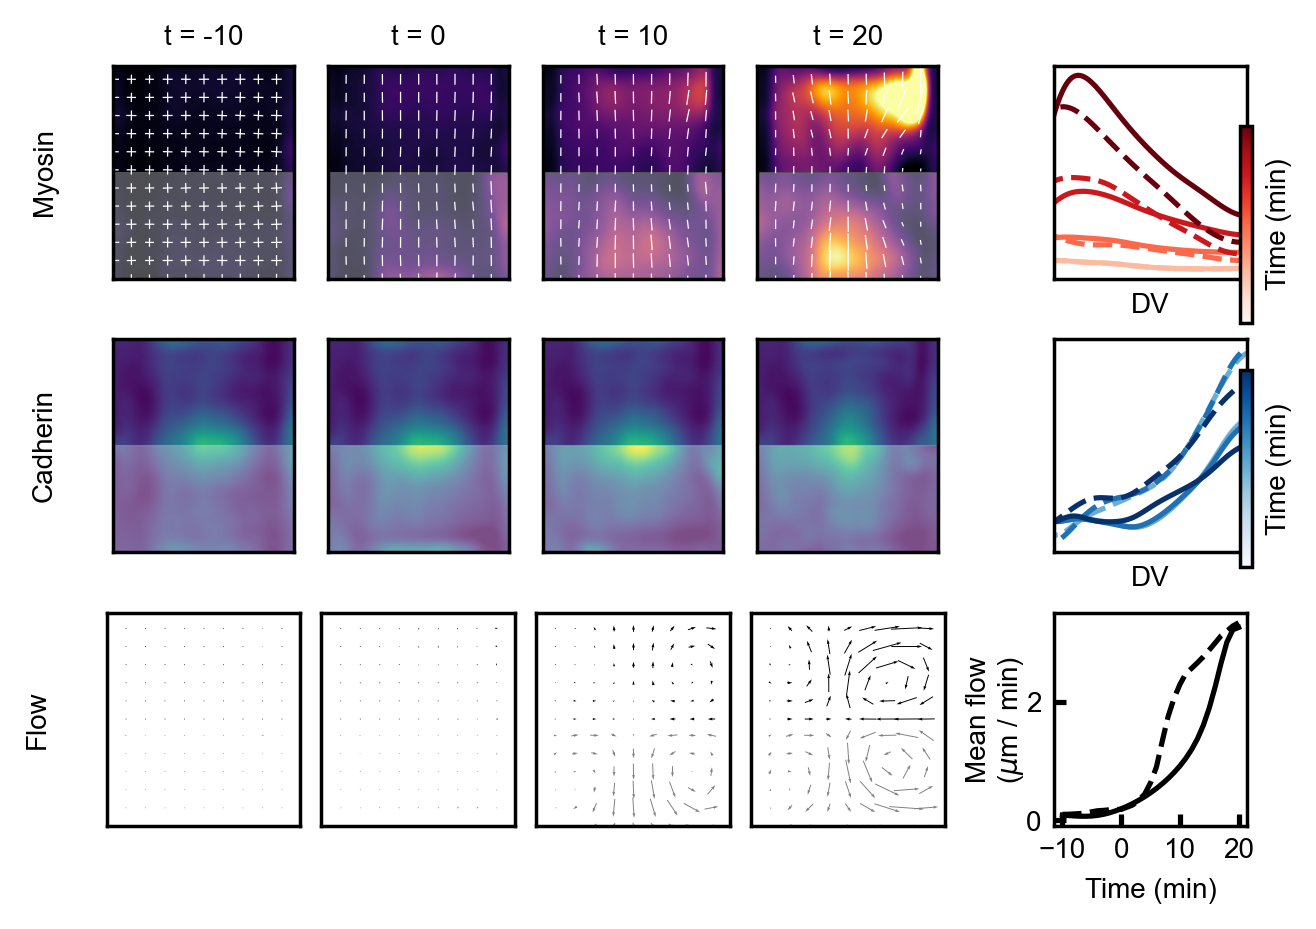

In [2]:
from morphogenesis.forecasting.closed_loop import ClosedFlyLoop
from morphogenesis.flow_networks.translation_models import VAE, MaskedVAE
from morphogenesis.flow_networks.forecasting_models import MaskedVAE_Evolver
from morphogenesis.forecasting.plot_utils import *
from morphogenesis.decomposition.decomposition_model import LeftRightSymmetrize
from morphogenesis.decomposition.decomposition_utils import get_decomposition_model
from morphogenesis.dataset import AtlasDataset
from pprint import pprint

import pickle
from sklearn.kernel_ridge import KernelRidge

# Collect model
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D')
sqh_model = get_decomposition_model(sqh_dataset, model_name='SVDPipeline_PMGCrop')

vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D')
vel_model = get_decomposition_model(vel_dataset, model_name='SVDPipeline_NoCrop')

with open('../04.TranslationNetworks/FlowKernelRidge.pkl', 'rb') as f:
    skmodel = pickle.load(f)

keep = np.ones(sqh_model.n_components, dtype=bool)
keep[skmodel.n_features_in_:] = False

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    features = sqh_model.transform(y)[:, keep]
    features = skmodel.predict(features)
    return vel_model.inverse_transform(features, keep)

#Collect initial conditions - m, c, v, and time
with h5py.File('../02.LearnDynamicsModel/myosin_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])

def rhs_eCad(self, m, s, v, E):
    '''
    Compute the right hand side of the myosin dynamics
    '''
    trm = self.einsum_('kkyx->yx', m)
    trE = self.einsum_('kkyx->yx', E)

    rhs  = -(0.110 - 0.095 * s) * m #Detachment
    rhs +=	(0.802 - 0.611 * s) * trm * m #Tension recruitment
    rhs +=	(0.708 + 0.133 * s) * m * trE #Strain recruitment
    rhs +=	(0.064 - 0.044 * s) * trm * self.gamma_dv_ #Hoop stress recruitment

    return rhs


model = ClosedFlyLoop(v_model, sigma=5, rhs=rhs_eCad)
model.fit(y0[None])

m, s, v = model.integrate(y0, t0)

comparison_plot(
    t0,
    ('Myosin', m, m0),
    ('Cadherin', s, s0),
    ('Flow', v, v0),
    dt=10)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1708.47it/s]


Using custom RHS
Using standard gradient
Initializing
Using scipy solve_ivp


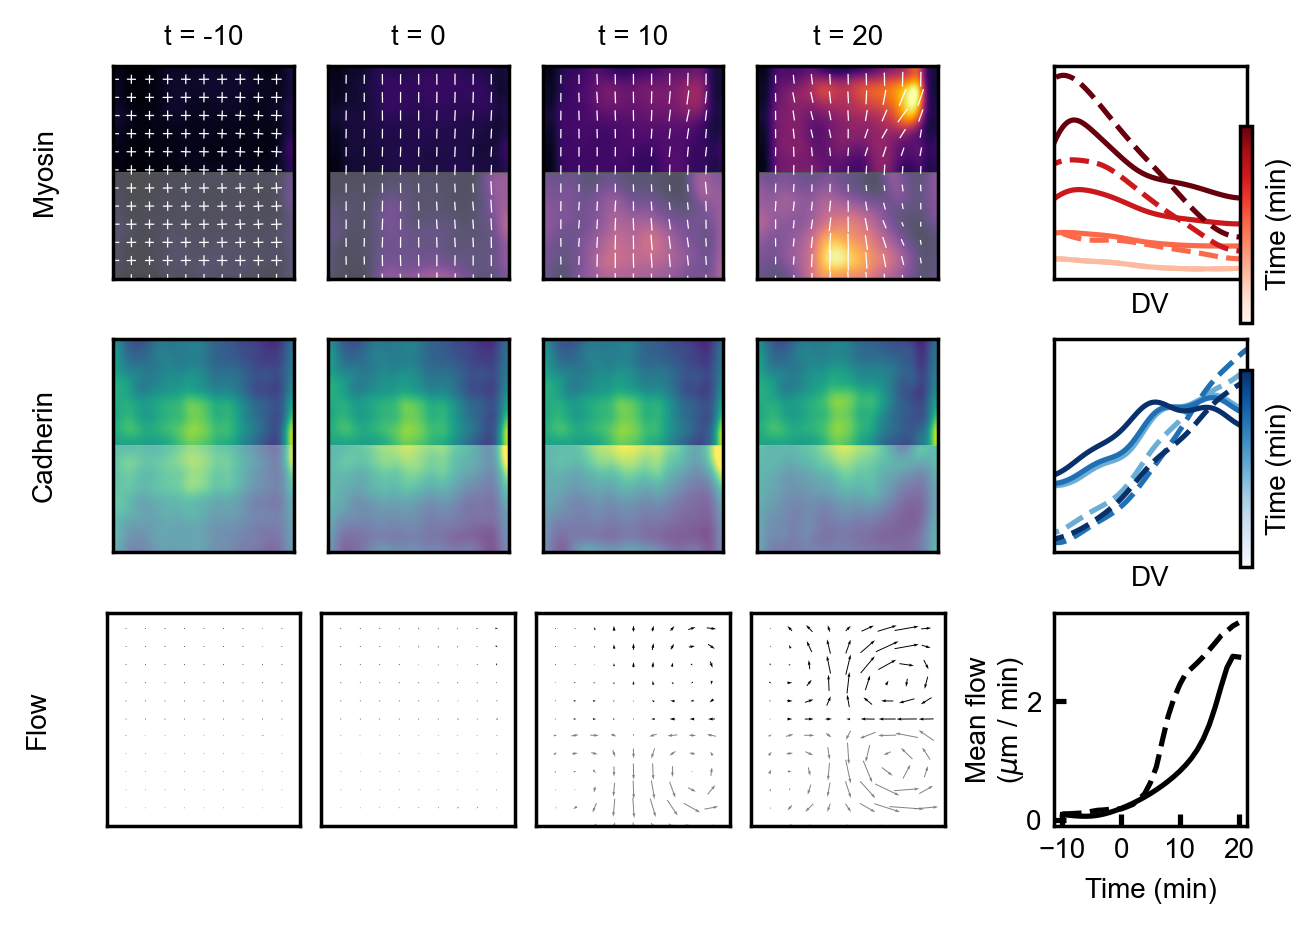

In [4]:
from morphogenesis.forecasting.closed_loop import ClosedFlyLoop
from morphogenesis.flow_networks.translation_models import VAE, MaskedVAE
from morphogenesis.flow_networks.forecasting_models import MaskedVAE_Evolver
from morphogenesis.forecasting.plot_utils import *
from morphogenesis.decomposition.decomposition_model import LeftRightSymmetrize
from morphogenesis.decomposition.decomposition_utils import get_decomposition_model
from morphogenesis.dataset import AtlasDataset
from pprint import pprint

import pickle
from sklearn.kernel_ridge import KernelRidge

# Collect model
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D')
sqh_model = get_decomposition_model(sqh_dataset, model_name='SVDPipeline_PMGCrop')

vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D')
vel_model = get_decomposition_model(vel_dataset, model_name='SVDPipeline_NoCrop')

with open('../04.TranslationNetworks/FlowKernelRidge.pkl', 'rb') as f:
    skmodel = pickle.load(f)

keep = np.ones(sqh_model.n_components, dtype=bool)
keep[skmodel.n_features_in_:] = False

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    features = sqh_model.transform(y)[:, keep]
    features = skmodel.predict(features)
    return vel_model.inverse_transform(features, keep)

#Collect initial conditions - m, c, v, and time
with h5py.File('../02.LearnDynamicsModel/myosin_fitting_with_actin.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])

def rhs_actin(model, m, s, v, E):
		'''
		Compute the right hand side of the myosin dynamics
			using actin as a "control" field instead of eCadherin
		'''
		trm = model.einsum_('kkyx->yx', m)
		trE = model.einsum_('kkyx->yx', E)

		rhs  = -(0.215 - 0.200 * s) * m #Detachment
		rhs +=	(1.447 - 1.288 * s) * trm * m #Tension recruitment
		rhs +=	(0.720 + 0.127 * s) * m * trE #Strain recruitment
		rhs +=	(0.098 - 0.076 * s) * trm * model.gamma_dv_ #Hoop stress recruitment

		return rhs

model = ClosedFlyLoop(v_model, sigma=5, rhs=rhs_actin)
model.fit(y0[None])

m, s, v = model.integrate(y0, t0)

comparison_plot(
    t0,
    ('Myosin', m, m0),
    ('Cadherin', s, s0),
    ('Flow', v, v0),
    dt=10)